# Climate Analysis and Exploration

In [1]:
# Dependencies for python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn

In [2]:
# Dependencies for SQLAlchemy
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy import func

In [3]:
# Create engine 
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [5]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurements', 'stations']

In [7]:
# Assign the classes to respective tables
Measurements = Base.classes.measurements
Stations = Base.classes.stations

In [8]:
# Create session
session = Session(engine)

# Precipitation Analysis

In [9]:
# Check measurement data and display in dictionary format
measurements_data = session.query(Measurements).first()
measurements_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1722c6bcfd0>,
 'date': datetime.date(2010, 1, 1),
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0}

In [10]:
# Find the most recent date
from datetime import datetime
most_recent = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
most_recent 

(datetime.date(2017, 8, 23))

In [11]:
# Find the date a year before from most recent
last_date = most_recent[0]
year_before = last_date.replace(year = (last_date.year - 1))
year_before = year_before.strftime("%Y-%m-%d")
year_before

'2016-08-23'

In [12]:
# Query to retrive the last 12 months of precipitation data
precip_data = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= year_before).order_by(Measurements.date)

In [13]:
# Load the query result to dataframe
precip_df = pd.read_sql(precip_data.statement, precip_data.session.bind)
precip_df.set_index('date', inplace=True)
precip_df.head(20)

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.00
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15


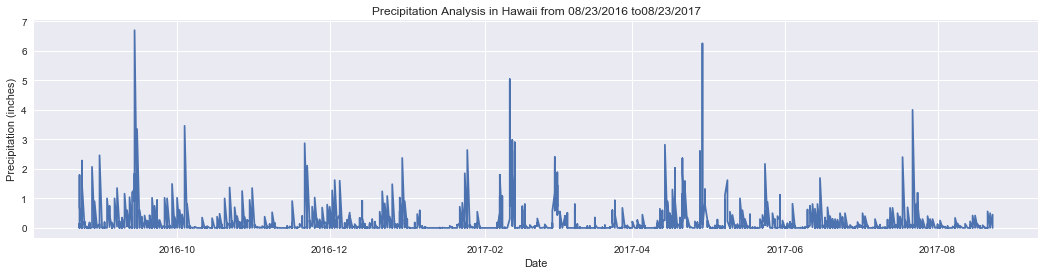

In [14]:
# Plot the precipitation
plt.figure(figsize=(18,4))
plt.plot(precip_df.index, precip_df["prcp"])
plt.ylabel("Precipitation (inches)")
plt.xlabel("Date")
plt.title("Precipitation Analysis in Hawaii from 08/23/2016 to08/23/2017")

# Save an image of the chart and print to screen
plt.savefig("Outputs/Precipitation Analysis.png")
plt.show()

In [15]:
# Summary Statistics
precip_df.describe()

,prcp
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Station Analysis


In [16]:
# Check measurement data and display in dictionary format
station_data = session.query(Stations).first()
station_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1722c750160>,
 'elevation': 3.0,
 'id': 1,
 'latitude': 21.2716,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397'}

In [17]:
# Query to calculate the number of stations
StationCount = session.query(Stations.id).count()
StationCount

9

In [18]:
# Find the most active station
StationActivity = session.query(Stations.station, Stations.name, Measurements.station, 
                func.count(Measurements.tobs)).filter(Stations.station == Measurements.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()
StationActivity

[('USC00519281', 'WAIHEE 837.5, HI US', 'USC00519281', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 'USC00519397', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 'USC00513117', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 'USC00519523', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 'USC00516128', 2612),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  'USC00514830',
  2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 'USC00511918', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 'USC00517948', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 'USC00518838', 511)]

In [19]:
# Most active station with highest number of observations
MostActive = StationActivity[0][0:2]
MostActive

('USC00519281', 'WAIHEE 837.5, HI US')

In [20]:
# Retrieve last 12 months of temperature observation data
tobs = session.query(Measurements.date, Measurements.tobs).filter(Measurements.date>=year_before).filter(Measurements.station==MostActive[0]).order_by(Measurements.date).all()

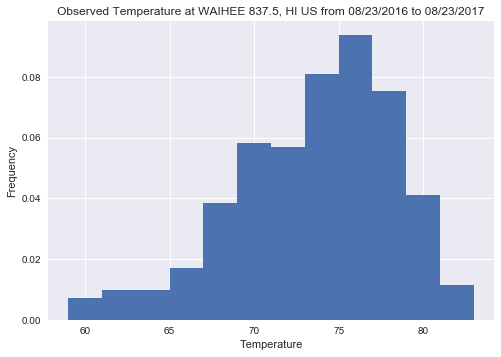

In [21]:
# Plot the observation as a histogram
temps = [x[1] for x in tobs]
plt.hist(temps, normed=True, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.title("Observed Temperature at %s from 08/23/2016 to 08/23/2017" % (MostActive[1]))

# Save an image of the chart and print to screen
plt.savefig("Outputs/Station Analysis.png")
plt.show()

# Temperature Analysis

In [22]:
# Write a function calc_temps that will accept a start date and end date in the format %Y-%m-%d and 
# return the minimum, average, and maximum temperatures for that range of dates.
class Temp():
    def __init__(self, minimum, average, maximum):
        self.minimum = minimum
        self.average = average
        self.maximum = maximum
        
def calc_temps(start_date, end_date):
    minimum = session.query(func.min(Measurements.tobs)).filter(Measurements.date.between(start_date, end_date)).scalar()
    print(f"Minimum temp: {minimum}")
    average = session.query(func.round(func.avg(Measurements.tobs))).filter(Measurements.date.between(start_date, end_date)).scalar()
    print(f"Average temp: {average}")
    maximum = session.query(func.max(Measurements.tobs)).filter(Measurements.date.between(start_date, end_date)).scalar()
    print(f"Maximum temp: {maximum}")
    
    result = [{"Minimum":minimum},{"Maximum":maximum},{"Average":average}]
    result = Temp(minimum, average, maximum)
    return result    

t = calc_temps('2017-07-01','2017-07-15')
t.minimum, t.average, t.maximum

Minimum temp: 69.0
Average temp: 78.0
Maximum temp: 87.0


(69.0, 78.0, 87.0)

In [23]:
# Find the results for previous year for same dates
previousYearTemps = calc_temps('2016-07-01','2016-07-15')
previousYearTemps.minimum, previousYearTemps.average, previousYearTemps.maximum

Minimum temp: 71.0
Average temp: 77.0
Maximum temp: 82.0


(71.0, 77.0, 82.0)

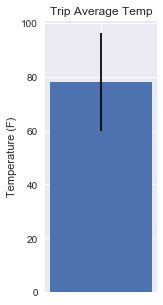

In [24]:
# create bar graph
plt.figure(figsize=(2,5))
plt.title("Trip Average Temp")
plt.ylabel("Temperature (F)")
plt.bar(1, t.average, yerr = (t.maximum - t.minimum), tick_label = "")

# Save an image of the chart and print to screen
plt.savefig("Outputs/Temperature Analysis.png")
plt.show()

# Rainfall Analysis

In [25]:
# rainfall per weather station
RainfallPerStation = session.query(Measurements.station,func.sum(Measurements.prcp)).filter(Measurements.date.between('2016-07-01','2016-07-15')).group_by(Measurements.station).all()
RainfallPerStation

[('USC00513117', 1.78),
 ('USC00514830', 1.45),
 ('USC00516128', 7.569999999999999),
 ('USC00517948', 0.0),
 ('USC00519281', 3.3000000000000003),
 ('USC00519397', 0.5700000000000001),
 ('USC00519523', 1.31)]